### Explore effect of different focal ratio

In [2]:
%pylab inline
import astropy.units as u
import tmm
from Getindex import load_refraction_data
index_of_refraction = load_refraction_data(Epoxy_ind=1.6,Temp = 173.)
import TMMSIM
from numba import jit
from tqdm import tqdm
from astropy.io import fits
import astropy.units as u
import os
import pickle
from scipy import interpolate
import bandpass

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Load the Interpolator
dbfile = open('data/Interpolator.pkl', 'rb')  
interpolator = pickle.load(dbfile)
dbfile.close()

Populating the interactive namespace from numpy and matplotlib


In [3]:
@jit(nopython = True,nogil=True)
def E2V_model(n_list,epoxy_um, wlen):
    
    thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,epoxy_um,160, np.inf])

    # Assume normal incidence.
    theta = 0.
    R = T = 0
    for pol in 's':

        # Using tmm package to do multilayer thin-film simulation
        Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        # Store R and T results
        rr,tt = Res[2],Res[3]
        R += rr
        T += tt

    A = 1 - R - T
    return(A)

# Run the sim once for numba
pol = 's'
wlen = 985.1
material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
n_list = np.array([index_of_refraction[m](wlen) for m in material])
thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,17.2,165, np.inf])
Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, 9.5/180*pi, 1e-3 * wlen)


/Users/zhiyuanguo/Documents/Research/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


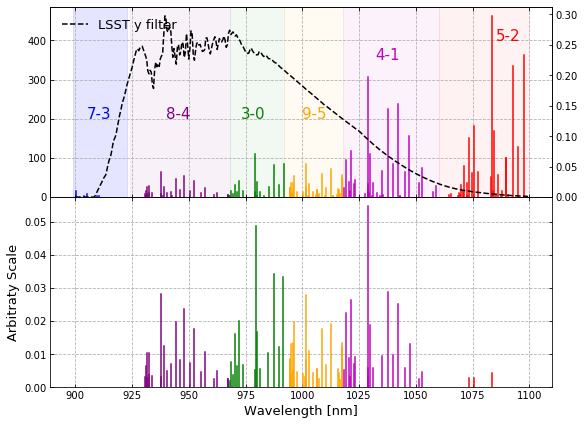

In [5]:
# Plot OH spec 
wavelength,intensity = bandpass.sky_line()
filter_wlen,filter_thr = bandpass.lsst_y_filter()
wlenmin = 900
wlenmax = 1100
res = bandpass.conv(wlen_min = wlenmin, wlen_max= wlenmax,Int_lim=1)
wavelengths = np.round(wavelength[res[0]][res[2]],1)
line_strength = res[1]
intensity_filter = res[2]

# Get the normalized weighted for each emission line
line_weight = line_strength[intensity_filter]/np.sum(line_strength[intensity_filter])

bandpass.plot_conved2(res[0],res[1],res[2])

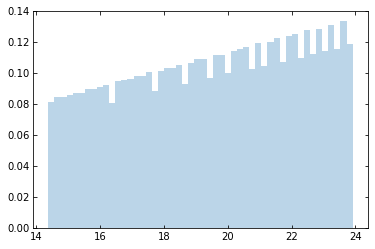

In [46]:
# Incident angle distribution for one pixel on CCD and corresponding weight using batoid
angles,weight = bandpass.get_angle(theta_x=0,theta_y=0);

In [7]:
# load the Epoxy thickness map of E2V-321
hh = fits.open('data/E2V-321.fits')
MAP = hh[1].data['sim']
MAP = np.array(MAP,dtype = float)
Fitting = MAP.reshape(3974,4000)


def Fringe_sim2 (inter_func,incident_angle,Weight,thickness):
    z_new = inter_func(thickness,incident_angle)
    z_new = z_new.reshape(len(z_new))
    count = np.sum(z_new*Weight)
    return(count)

In [47]:

LSST_center= np.zeros(shape=(1,4000))
for k in tqdm(range(len(wavelengths))):
    fringing_res3 = np.zeros(shape=(1,4000))
    for i in (range(fringing_res3.shape[0])):
        for j in range(fringing_res3.shape[1]):
                fringing_res3[i,j] += Fringe_sim2(inter_func=interpolator[str(wavelengths[k])],
                                                 incident_angle = angles, Weight= weight,thickness = Fitting[i+500,j])
    LSST_center += (fringing_res3)*line_weight[k]

100%|██████████| 89/89 [00:12<00:00,  7.18it/s]


In [59]:
def plot_amp (sim_result):
    fig, ax1 = plt.subplots(nrows=1,sharex=True)
    ax2 = ax1.twinx()
    ax1.plot(sim_result)
    ax1.set_ylabel('Absorption in Silicon')
    ax2.plot(sim_result/np.mean(sim_result)-1)
    ax2.set_ylabel('Fringing Amplitude')
    ax2.axhline(0,ls = '--',color = 'black')
    return(ax1)

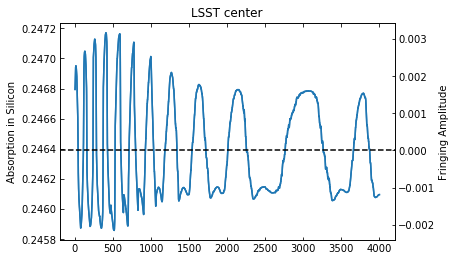

In [61]:

ax = plot_amp(LSST_center[0])
ax.set_title('LSST center');

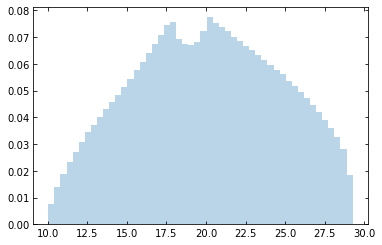

In [38]:
# Incident angle distribution for one pixel on CCD and corresponding weight using batoid
# Edge of the Field of view on the focal plane
angles,weight = bandpass.get_angle(theta_x=1.2,theta_y=0.8);

In [40]:
LSST_edge= np.zeros(shape=(1,4000))
for k in tqdm(range(len(wavelengths))):
    fringing_res3 = np.zeros(shape=(1,4000))
    for i in (range(fringing_res3.shape[0])):
        for j in range(fringing_res3.shape[1]):
                fringing_res3[i,j] += Fringe_sim2(inter_func=interpolator[str(wavelengths[k])],
                                                 incident_angle = angles, Weight= weight,thickness = Fitting[i+500,j])
    LSST_edge += (fringing_res3)*line_weight[k]

100%|██████████| 89/89 [00:12<00:00,  7.14it/s]


Text(0.5, 1.0, 'LSST edge')

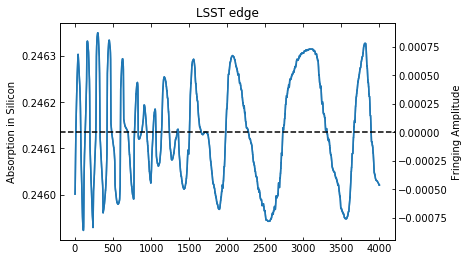

In [62]:
ax = plot_amp(LSST_edge[0])
ax.set_title('LSST edge')

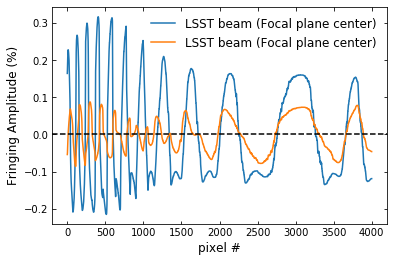

In [64]:
plt.figure(figsize = (6,4))
#plt.title('LSST f/1.234 center')

g1 = np.mean(LSST_center[0])
plt.plot((LSST_center[0]/g1-1)*100,label = 'LSST beam (Focal plane center)')

g2 = np.mean(LSST_edge[0])
plt.plot((LSST_edge[0]/g2-1)*100,label = 'LSST beam (Focal plane center)')

plt.axhline(0,ls = '--',color = 'black')
plt.ylabel('Fringing Amplitude (%)',fontsize = 12)
plt.xlabel('pixel #',fontsize = 12)
plt.legend(loc = 'best',frameon = False,fontsize = 12)
plt.savefig('data/Paper_plots/LSST-fringing-sims.eps')
#plt.ylim(-0.3,)

In [65]:
# Run sim for MonoCam

interpolators = {}
# y incident angle
th_min=0.1*u.deg 
th_max=7.13*u.deg
th_rad = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 100)
# x wavelength
MAP = np.arange(14.02,22.01,0.01)
x = MAP
y = th_rad
for i in tqdm(range(len(wavelengths))):
    z = []
    wlen = wavelengths[i]
    material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
    n_list = np.array([index_of_refraction[m](wlen) for m in material])
    pol = 's'
    for j in (range(len(th_rad))):
        theta = th_rad[j]
        a = []
        for i in (range(len(MAP))):

            thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,MAP[i],165, np.inf])
            Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
            Abor_prob = TMMSIM.absorp_in_each_layer(Res)[3]
            a.append(Abor_prob)
        z.append(a)

    interpolators[str(wlen)] = interpolate.interp2d(x, y, z, kind='cubic')

100%|██████████| 89/89 [14:59<00:00, 10.10s/it]


In [66]:
angles = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 100)
weight = angles / np.sum(angles)

In [69]:
index_of_refraction = load_refraction_data(Epoxy_ind=1.6,Temp = 173.)

In [67]:
stacked_image_mono = np.zeros(shape=(1,4000))
for k in tqdm(range(len(wavelengths))):
    fringing_res3 = np.zeros(shape=(1,4000))
    for i in (range(fringing_res3.shape[0])):
        for j in range(fringing_res3.shape[1]):
                fringing_res3[i,j] += Fringe_sim2(inter_func=interpolators[str(wavelengths[k])],
                                                 incident_angle = angles, Weight= weight,thickness = Fitting[i+500,j])
    stacked_image_mono += fringing_res3*line_weight[k]

100%|██████████| 89/89 [00:11<00:00,  7.42it/s]


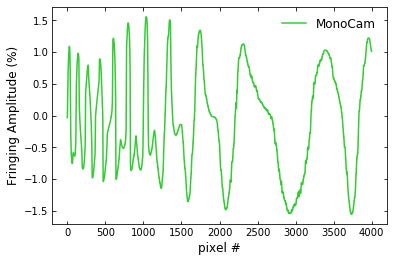

In [68]:
#plt.title('Monocam f/4')
plt.figure(figsize = (6,4))
g = (np.max(stacked_image_mono[0])+np.min(stacked_image_mono[0]))/2
plt.ylabel('Fringing Amplitude (%)',fontsize = 12)
plt.xlabel('pixel #',fontsize = 12)
plt.plot((stacked_image_mono[0]/g-1)*100,label = 'MonoCam',color = 'limegreen')
plt.legend(loc = 'best',frameon= False,fontsize = 12)
plt.savefig('data/Paper_plots/MonoCam_sims.eps')

In [ ]:
## Detailed sky spectrum 

In [17]:
file = 'data/ybandlines.txt'

wavelength = np.loadtxt(file,usecols=[0])
intensity = np.loadtxt(file,usecols=[1])
group = np.loadtxt(file,usecols=[4])

In [3]:
# sky line files from 
file = 'data/ybandlines.txt'

wavelength = np.loadtxt(file,usecols=[0])
intensity = np.loadtxt(file,usecols=[1])
group = np.loadtxt(file,usecols=[4])

# LSST y filter throughput
y_filter = 'data/throughputs/baseline/total_y.dat'
yband_wlen = np.round(np.loadtxt(y_filter,usecols=[0]),1)
yband_throughput = np.loadtxt(y_filter,usecols=[1])

# Rel intensity over time from Noll.S et al 2015v
group73 = (group == 73)
group84 = (group == 84)
group30 = (group == 30)
group95 = (group == 95)
group41 = (group == 41)
group52 = (group == 52)
group_n = (group == 0)
groups = [group73,group84,group30,group95,group41,group52,group_n]
vib_group = ['7-3','8-4','3-0','9-5','4-1','5-2','Unidentified']
eight = [2.26,1.82,1.12,0.67,0.57,0.5,0.614,0.8,0.956,1.065,0.886]
three = [2.825,2.316,1.491,0.768,0.513,0.368,0.373,0.552,0.68,0.768,0.7]
nine = [2.206,1.689,1.114,0.70,0.592,0.539,0.649,0.855,0.987,1.092,0.9]
four = [2.768,2.307,1.434,0.732,0.509,0.4,0.439,0.636,0.763,0.851,0.741]
five = [2.645,2.118,1.329,0.706,0.526,0.43,0.5,0.715,0.868,0.969,0.75]
Time = [0,1,2,3,4,5,6,7,8,9,10]
ac_time = ['7:00 pm','8:00 pm','9:00 pm','10:00 pm','11:00 pm','12:00 am','1:00 am','2:00 am','3:00 am','4:00 am','5:00 am']
Scales = [eight,three,nine,four,five]

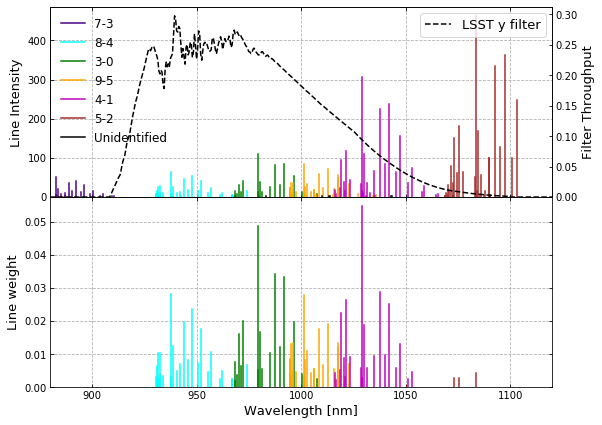

In [11]:
conv_spec = np.zeros(shape = wavelength.shape)
for g in (groups):
    band_range = np.round(wavelength[g],1)
    intensity_range = intensity[g]*1
    spec_indx = np.where(g == True)[0]
    for i in range(len(band_range)):
        indx = np.where(yband_wlen == band_range[i])[0]
        actual = yband_throughput[indx]*intensity_range[i]
        conv_spec[spec_indx[i]] = actual[0]
colors = ['indigo','aqua','green','orange','m','brown','black']
fig, ax1 = plt.subplots(nrows=2, figsize = (9,7),sharex=True)
plt.subplots_adjust(hspace=0,wspace=0)
#ax1[0].set_title(str(ac_time[q]),fontsize = 17)
ax2 = ax1[0].twinx()
for g,c,l in zip(groups,colors,vib_group):
    for i in range(len(wavelength[g])):
        if i == 0:
            ax1[0].plot([wavelength[g][i],wavelength[g][i]],[0,intensity[g][i]]*1,color = c,label = l)

        ax1[0].plot([wavelength[g][i],wavelength[g][i]],[0,intensity[g][i]]*1,color = c)
        #ax1[0].plot([wavelength_range[i],wavelength_range[i]], [0,intensity[limit[0]:limit[1]][i]*scale[time]], color = c)
ax1[0].grid(ls='--')
ax1[0].set_ylabel('Line Intensity',fontsize = 13)
ax1[0].set_ylim(0,)
ax1[0].set_xlim(880,1120)
ax1[0].legend(fontsize= 12,frameon = False)



ax2.plot(yband_wlen[5800:],yband_throughput[5800:],color = 'black',ls = '--',label = 'LSST y filter')
ax2.legend(fontsize = 13)
ax2.set_ylim(0,)
ax2.set_ylabel('Filter Throughput',fontsize= 13)




norm_spec = conv_spec/np.sum(conv_spec)
for g,c in zip(groups,colors):
    intensity_f = conv_spec[g] >= 1
    for i in range(len(conv_spec[g][intensity_f])):
        ax1[1].plot([wavelength[g][intensity_f][i],wavelength[g][intensity_f][i]], [0,norm_spec[g][intensity_f][i]], color = c)   

ax1[1].set_ylim(0,)
#ax1[1].set_ylabel('Arbitraty Scale',fontsize = 13)
ax1[1].grid(ls='--');
ax1[1].set_xlabel('Wavelength [nm]',fontsize = 13)
ax1[1].set_ylabel('Line weight',fontsize = 13)
fig.savefig('data/Paper_plots/OH_spec.eps')